<a href="https://colab.research.google.com/github/mryeazel-729/MLHealth/blob/main/Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [28]:
import torch
import os
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import MNIST, SVHN
from torchvision.utils import make_grid
from tqdm import tqdm
import torch.nn.functional as F
import time

# Build Database

In [62]:
class PairedMNISTSVHN(Dataset):
    def __init__(self, mnist_data, svhn_data):
        self.mnist_data = mnist_data
        self.svhn_data = svhn_data

        # Create a dictionary to map labels to indices for SVHN
        self.svhn_label_dict = {i: [] for i in range(10)}
        for idx, (_, label) in enumerate(svhn_data):
            self.svhn_label_dict[label].append(idx)

    def __len__(self):
        return len(self.mnist_data)

    def __getitem__(self, idx):
        # Get the MNIST image and label
        mnist_img, mnist_label = self.mnist_data[idx]

        # Find a corresponding SVHN image with the same label
        svhn_idx = self.svhn_label_dict[mnist_label][idx % len(self.svhn_label_dict[mnist_label])]
        svhn_img, _ = self.svhn_data[svhn_idx]  # The label is already known

        return mnist_img, svhn_img, mnist_label

# Load MNIST and SVHN datasets
# Apply data augmentation to avoid overfitting during training
transform = transforms.Compose([
    transforms.Resize((32,32)), # Add resizing here
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

test_transform = transforms.Compose([
    transforms.Resize((32,32)), # Add resizing here
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
svhn_dataset = SVHN(root='./data', split='train', download=True, transform=transform)

# Load MNIST and SVHN datasets for testing without augmentation
mnist_test_dataset = MNIST(root='./data', train=False, download=True, transform=test_transform)
svhn_test_dataset = SVHN(root='./data', split='test', download=True, transform=test_transform)

# Create the paired dataset
paired_dataset = PairedMNISTSVHN(mnist_data=mnist_dataset, svhn_data=svhn_dataset)
paired_test_dataset = PairedMNISTSVHN(mnist_data=mnist_test_dataset, svhn_data=svhn_test_dataset)

# DataLoader for batching
paired_loader = DataLoader(paired_dataset, batch_size=64, shuffle=True)
paired_test_loader = DataLoader(paired_test_dataset, batch_size=64, shuffle=False)

# Example: Fetch one batch of paired data
mnist_imgs, svhn_imgs, labels = next(iter(paired_loader))

print(f"MNIST Batch Shape: {mnist_imgs.shape}")
print(f"SVHN Batch Shape: {svhn_imgs.shape}")
print(f"Labels: {labels[:10]}")

MNIST Batch Shape: torch.Size([64, 1, 32, 32])
SVHN Batch Shape: torch.Size([64, 3, 32, 32])
Labels: tensor([0, 1, 2, 3, 0, 2, 6, 2, 6, 8])


## Visualize Data

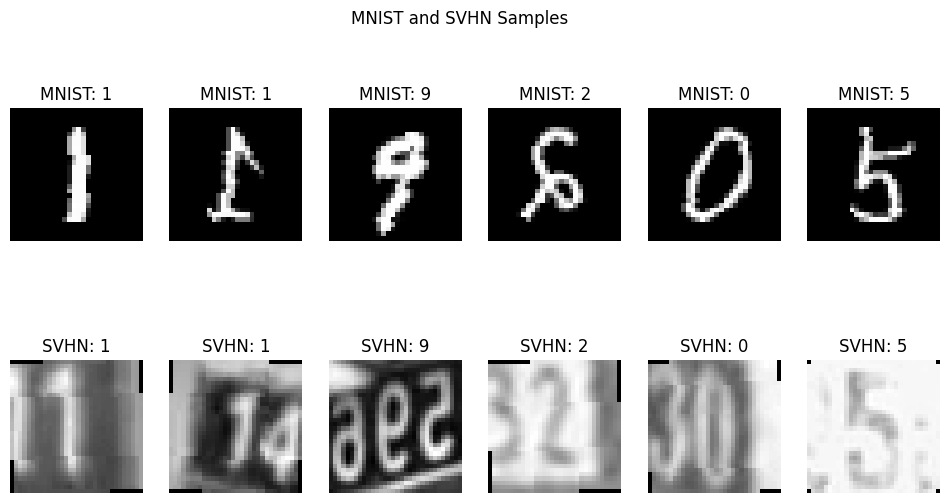

In [30]:
def visualize_paired_samples(loader, title):
    data_iter = iter(loader)
    mnist_images, svhn_images, labels = next(data_iter)

    plt.figure(figsize=(12, 6))

    # Visualize MNIST images
    for i in range(6):
        plt.subplot(2, 6, i + 1)
        plt.imshow(mnist_images[i][0], cmap='gray')
        plt.title(f"MNIST: {labels[i]}")
        plt.axis('off')

    # Visualize SVHN images
    for i in range(6):
        plt.subplot(2, 6, i + 7)
        plt.imshow(svhn_images[i][0], cmap='gray')
        plt.title(f"SVHN: {labels[i]}")
        plt.axis('off')

    plt.suptitle(title)
    plt.show()

# Visualize paired samples
visualize_paired_samples(paired_loader, "MNIST and SVHN Samples")

## Encoder

In [31]:
class ConvEncoderMNIST(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1), nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(True),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(True),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(128*4*4, latent_dim)
        self.fc_logvar = nn.Linear(128*4*4, latent_dim)
    def forward(self, x):
        h = self.conv(x)
        return self.fc_mu(h), self.fc_logvar(h)

class ConvEncoderSVHN(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1), nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(True),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(True),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(128*4*4, latent_dim)
        self.fc_logvar = nn.Linear(128*4*4, latent_dim)
    def forward(self, x):
        h = self.conv(x)
        return self.fc_mu(h), self.fc_logvar(h)

## Decoder

In [32]:
class ConvDecoderMNIST(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 128*4*4)
        self.deconv = nn.Sequential(
            nn.Unflatten(1, (128,4,4)),
            nn.ConvTranspose2d(128,64,4,2,1), nn.ReLU(True),
            nn.ConvTranspose2d(64,32,4,2,1), nn.ReLU(True),
            nn.ConvTranspose2d(32,1,4,2,1), nn.Sigmoid()
        )
    def forward(self, z):
        return self.deconv(self.fc(z))

class ConvDecoderSVHN(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 128*4*4)
        self.deconv = nn.Sequential(
            nn.Unflatten(1, (128,4,4)),
            nn.ConvTranspose2d(128,64,4,2,1), nn.ReLU(True),
            nn.ConvTranspose2d(64,32,4,2,1), nn.ReLU(True),
            nn.ConvTranspose2d(32,3,4,2,1), nn.Sigmoid()
        )
    def forward(self, z):
        return self.deconv(self.fc(z))

## Product of Experts

In [33]:
def product_of_experts(mu_list, logvar_list, eps=1e-8):
    mu = torch.stack(mu_list, dim=0)           # (n, batch, D)
    logvar = torch.stack(logvar_list, dim=0)
    var = torch.exp(logvar) + eps
    precision = 1.0 / var
    precision_sum = precision.sum(dim=0)
    mu_weighted = (mu * precision).sum(dim=0) / precision_sum
    var_poe = 1.0 / precision_sum
    logvar_poe = torch.log(var_poe + eps)
    return mu_weighted, logvar_poe

In [34]:
class JointVAE(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()
        self.latent_dim = latent_dim
        self.enc_mnist = ConvEncoderMNIST(latent_dim)
        self.enc_svhn = ConvEncoderSVHN(latent_dim)
        self.dec_mnist = ConvDecoderMNIST(latent_dim)
        self.dec_svhn = ConvDecoderSVHN(latent_dim)
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    def forward(self, x_mnist=None, x_svhn=None):
        mus = []
        logvars = []
        if x_mnist is not None:
            mu_m, logvar_m = self.enc_mnist(x_mnist)
            mus.append(mu_m); logvars.append(logvar_m)
        if x_svhn is not None:
            mu_s, logvar_s = self.enc_svhn(x_svhn)
            mus.append(mu_s); logvars.append(logvar_s)
        # add prior expert (mu=0, logvar=0 => var=1)
        if len(mus) == 0:
            # should not happen for training but keep safe
            mu_prior = torch.zeros((x_mnist.size(0), self.latent_dim), device=next(self.parameters()).device)
        else:
            mu_prior = torch.zeros_like(mus[0])
        logvar_prior = torch.zeros_like(mu_prior)
        mus.append(mu_prior); logvars.append(logvar_prior)
        mu_joint, logvar_joint = product_of_experts(mus, logvars)
        z = self.reparameterize(mu_joint, logvar_joint)
        x_mn_rec = self.dec_mnist(z)
        x_sv_rec = self.dec_svhn(z)
        return x_mn_rec, x_sv_rec, mu_joint, logvar_joint

# Model Training

## Loss Function

In [42]:
def reconstruction_loss(x_rec, x, view='mnist'):
    if x_rec is None or x is None:
        return 0.0
    if view=='mnist':
        return F.binary_cross_entropy(x_rec, x, reduction='sum')   # MNIST grayscale -> BCE
    else:
        return F.mse_loss(x_rec, x, reduction='sum')               # SVHN RGB -> MSE

def kl_gaussian(mu, logvar):
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

## Training Function

In [40]:
def train_one_epoch(model, dataloader, optimizer, device, beta=1.0):
    model.train()
    total_loss = 0.0
    total_rec = 0.0
    total_kl = 0.0
    for mn, sv, _ in tqdm(dataloader, desc="Train"):
        mn = mn.to(device); sv = sv.to(device)
        optimizer.zero_grad()
        mn_rec, sv_rec, mu, logvar = model(mn, sv)
        rec_m = reconstruction_loss(mn_rec, mn, 'mnist')
        rec_s = reconstruction_loss(sv_rec, sv, 'svhn')
        kl = kl_gaussian(mu, logvar)
        loss = rec_m + rec_s + beta * kl
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_rec += (rec_m + rec_s).item()
        total_kl += kl.item()
    n = len(dataloader.dataset)
    return total_loss / n, total_rec / n, total_kl / n

def evaluate(model, dataloader, device, n_batches=50):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for i, (mn, sv, _) in enumerate(dataloader):
            mn = mn.to(device); sv = sv.to(device)
            mn_rec, sv_rec, mu, logvar = model(mn, sv)
            rec_m = reconstruction_loss(mn_rec, mn, 'mnist')
            rec_s = reconstruction_loss(sv_rec, sv, 'svhn')
            kl = kl_gaussian(mu, logvar)
            total_loss += (rec_m + rec_s + kl).item()
            if i+1 >= n_batches:
                break
    return total_loss / (n_batches * dataloader.batch_size)

## Data Loader

In [49]:
batch_size = 128
latent_dim = 64
lr = 1e-3
epochs = 20
beta = 1.0

transform_mnist = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor()
])
transform_svhn = transforms.Compose([
    transforms.ToTensor()
])

mnist_train_dataset = MNIST(root="./data", train=True, download=True, transform=transform_mnist)
svhn_train_dataset = SVHN(root="./data", split="train", download=True, transform=transform_svhn)

mnist_test_dataset = MNIST(root="./data", train=False, download=True, transform=transform_mnist)
svhn_test_dataset = SVHN(root="./data", split="test", download=True, transform=transform_svhn)

train_dataset = PairedMNISTSVHN(mnist_data=mnist_train_dataset, svhn_data=svhn_train_dataset)
test_dataset  = PairedMNISTSVHN(mnist_data=mnist_test_dataset, svhn_data=svhn_test_dataset)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = JointVAE(latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
print("Train dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))

Train dataset size: 60000
Test dataset size: 10000


In [50]:
best_loss = 1e9
for ep in range(1, epochs+1):
    t0 = time.time()
    train_loss, rec_loss, kl_loss = train_one_epoch(model, train_loader, optimizer, device, beta=beta)
    val_loss = evaluate(model, test_loader, device, n_batches=20)
    t1 = time.time()
    print(f"Epoch {ep}/{epochs}  train_loss={train_loss:.4f} (rec={rec_loss:.4f}, kl={kl_loss:.4f})  val_loss={val_loss:.4f}  time={(t1-t0):.1f}s")
    # checkpoint
    ckpt_path = f"joint_vae_epoch{ep}.pth"
    torch.save(model.state_dict(), ckpt_path)
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "joint_vae_best.pth")
        print("Saved best checkpoint.")

Train: 100%|██████████| 469/469 [03:33<00:00,  2.20it/s]


Epoch 1/20  train_loss=292.4585 (rec=269.8624, kl=22.5962)  val_loss=212.4831  time=217.3s
Saved best checkpoint.


Train: 100%|██████████| 469/469 [03:33<00:00,  2.20it/s]


Epoch 2/20  train_loss=200.3451 (rec=168.1763, kl=32.1687)  val_loss=196.7982  time=217.3s
Saved best checkpoint.


Train: 100%|██████████| 469/469 [03:34<00:00,  2.19it/s]


Epoch 3/20  train_loss=192.4647 (rec=159.7373, kl=32.7273)  val_loss=193.2080  time=217.7s
Saved best checkpoint.


Train: 100%|██████████| 469/469 [03:33<00:00,  2.19it/s]


Epoch 4/20  train_loss=189.5355 (rec=156.8007, kl=32.7348)  val_loss=190.6743  time=217.5s
Saved best checkpoint.


Train: 100%|██████████| 469/469 [03:33<00:00,  2.20it/s]


Epoch 5/20  train_loss=187.4268 (rec=154.2305, kl=33.1963)  val_loss=189.0971  time=217.9s
Saved best checkpoint.


Train: 100%|██████████| 469/469 [03:33<00:00,  2.19it/s]


Epoch 6/20  train_loss=186.0778 (rec=152.7372, kl=33.3406)  val_loss=187.0646  time=218.5s
Saved best checkpoint.


Train: 100%|██████████| 469/469 [03:33<00:00,  2.19it/s]


Epoch 7/20  train_loss=184.7343 (rec=151.0342, kl=33.7002)  val_loss=186.6706  time=217.4s
Saved best checkpoint.


Train: 100%|██████████| 469/469 [03:33<00:00,  2.19it/s]


Epoch 8/20  train_loss=183.8122 (rec=150.1368, kl=33.6754)  val_loss=185.0609  time=217.5s
Saved best checkpoint.


Train: 100%|██████████| 469/469 [03:33<00:00,  2.20it/s]


Epoch 9/20  train_loss=183.1329 (rec=149.4796, kl=33.6533)  val_loss=184.6021  time=216.7s
Saved best checkpoint.


Train: 100%|██████████| 469/469 [03:33<00:00,  2.20it/s]


Epoch 10/20  train_loss=182.5616 (rec=148.9509, kl=33.6107)  val_loss=184.8715  time=217.2s


Train: 100%|██████████| 469/469 [03:33<00:00,  2.20it/s]


Epoch 11/20  train_loss=181.8785 (rec=148.1372, kl=33.7413)  val_loss=183.3722  time=216.9s
Saved best checkpoint.


Train: 100%|██████████| 469/469 [03:31<00:00,  2.21it/s]


Epoch 12/20  train_loss=181.3786 (rec=147.5279, kl=33.8507)  val_loss=183.0985  time=215.5s
Saved best checkpoint.


Train: 100%|██████████| 469/469 [03:33<00:00,  2.20it/s]


Epoch 13/20  train_loss=180.8501 (rec=146.8659, kl=33.9842)  val_loss=181.4013  time=217.9s
Saved best checkpoint.


Train: 100%|██████████| 469/469 [03:33<00:00,  2.20it/s]


Epoch 14/20  train_loss=180.3131 (rec=146.0663, kl=34.2468)  val_loss=181.3930  time=218.0s
Saved best checkpoint.


Train: 100%|██████████| 469/469 [03:33<00:00,  2.20it/s]


Epoch 15/20  train_loss=179.9346 (rec=145.7330, kl=34.2017)  val_loss=181.2786  time=217.1s
Saved best checkpoint.


Train: 100%|██████████| 469/469 [03:33<00:00,  2.19it/s]


Epoch 16/20  train_loss=179.6623 (rec=145.4623, kl=34.2000)  val_loss=181.1650  time=217.4s
Saved best checkpoint.


Train: 100%|██████████| 469/469 [03:33<00:00,  2.20it/s]


Epoch 17/20  train_loss=179.3284 (rec=145.1693, kl=34.1591)  val_loss=180.7616  time=217.1s
Saved best checkpoint.


Train: 100%|██████████| 469/469 [03:34<00:00,  2.19it/s]


Epoch 18/20  train_loss=179.1107 (rec=144.9565, kl=34.1542)  val_loss=180.1988  time=218.0s
Saved best checkpoint.


Train: 100%|██████████| 469/469 [03:33<00:00,  2.20it/s]


Epoch 19/20  train_loss=178.8242 (rec=144.6852, kl=34.1390)  val_loss=180.2773  time=217.1s


Train: 100%|██████████| 469/469 [03:33<00:00,  2.20it/s]


Epoch 20/20  train_loss=178.6029 (rec=144.5128, kl=34.0901)  val_loss=180.0795  time=217.8s
Saved best checkpoint.


# Display

In [51]:
def show_images(tensor_list, nrow=8, figsize=(10,10), title=None):
    grid = make_grid(torch.stack(tensor_list).cpu(), nrow=nrow)
    npimg = grid.numpy()
    plt.figure(figsize=figsize)
    if npimg.shape[0]==1:
        plt.imshow(npimg[0], cmap='gray')
    else:
        plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.axis('off')
    if title: plt.title(title)
    plt.show()

## Reconstructions

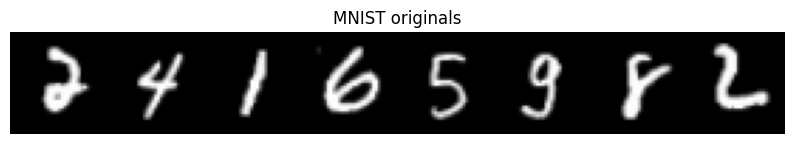

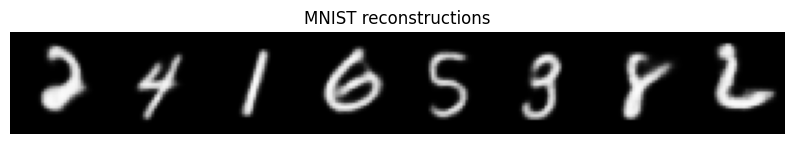

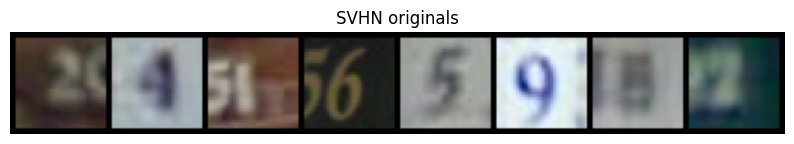

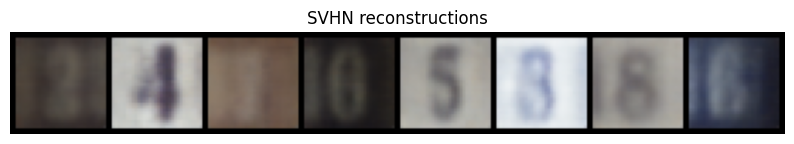

In [70]:
model.eval()
idxs = np.random.choice(len(test_dataset), 8, replace=False)
orig_mn, orig_sv, rec_mn, rec_sv = [], [], [], []
with torch.no_grad():
    for i in idxs:
        mn, sv, _ = test_dataset[i]
        mn_t = mn.unsqueeze(0).to(device); sv_t = sv.unsqueeze(0).to(device)
        mn_r, sv_r, _, _ = model(mn_t, sv_t)
        orig_mn.append(mn); orig_sv.append(sv)
        rec_mn.append(mn_r.squeeze(0).cpu()); rec_sv.append(sv_r.squeeze(0).cpu())

show_images(orig_mn, nrow=8, title="MNIST originals")
show_images(rec_mn, nrow=8, title="MNIST reconstructions")
show_images(orig_sv, nrow=8, title="SVHN originals")
show_images(rec_sv, nrow=8, title="SVHN reconstructions")

## Sampling from Prior

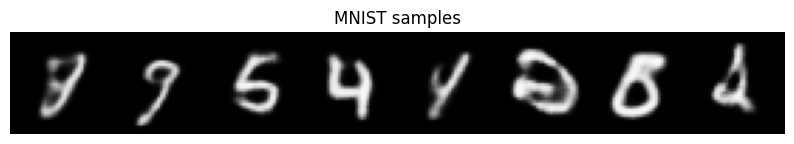

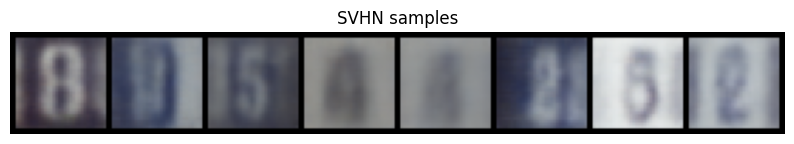

In [71]:
with torch.no_grad():
    z = torch.randn(8, model.latent_dim).to(device)
    mn_samples = model.dec_mnist(z)
    sv_samples = model.dec_svhn(z)
show_images([mn_samples[i].cpu() for i in range(8)], nrow=8, title="MNIST samples")
show_images([sv_samples[i].cpu() for i in range(8)], nrow=8, title="SVHN samples")

## Cross-Domain

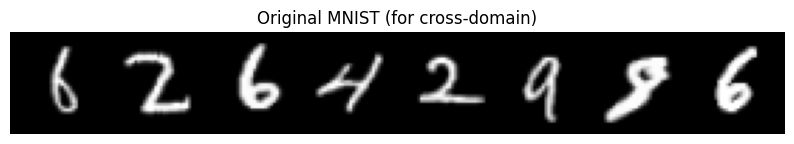

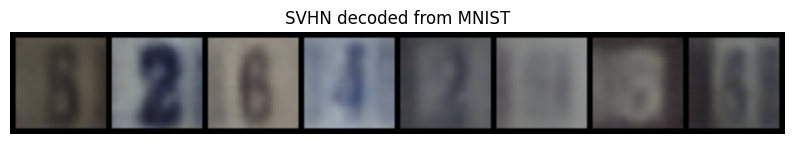

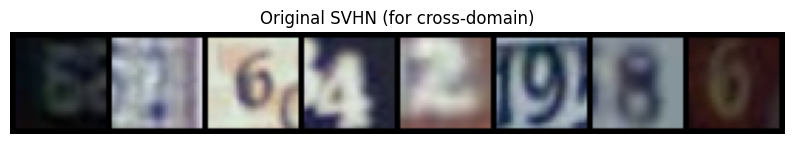

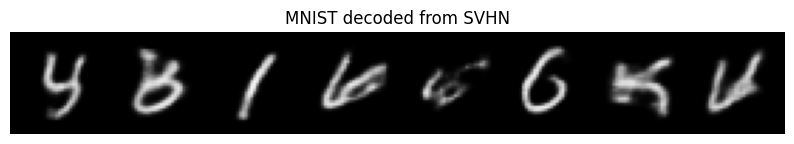

In [54]:
# Encode MNIST only -> decode SVHN, and vice versa
mn_from_sv, sv_from_mn, orig_mn2, orig_sv2 = [], [], [], []
with torch.no_grad():
    idxs = np.random.choice(len(test_dataset), 8, replace=False)
    for i in idxs:
        mn, sv, _ = test_dataset[i]
        orig_mn2.append(mn); orig_sv2.append(sv)
        # MN -> z -> SV
        mu_m, logvar_m = model.enc_mnist(mn.unsqueeze(0).to(device))
        mu_j, logvar_j = product_of_experts([mu_m, torch.zeros_like(mu_m)], [logvar_m, torch.zeros_like(mu_m)])
        z_m = model.reparameterize(mu_j, logvar_j)
        sv_from_mn.append(model.dec_svhn(z_m).squeeze(0).cpu())
        # SV -> z -> MN
        mu_s, logvar_s = model.enc_svhn(sv.unsqueeze(0).to(device))
        mu_j2, logvar_j2 = product_of_experts([mu_s, torch.zeros_like(mu_s)], [logvar_s, torch.zeros_like(mu_s)])
        z_s = model.reparameterize(mu_j2, logvar_j2)
        mn_from_sv.append(model.dec_mnist(z_s).squeeze(0).cpu())

show_images(orig_mn2, nrow=8, title="Original MNIST (for cross-domain)")
show_images(sv_from_mn, nrow=8, title="SVHN decoded from MNIST")
show_images(orig_sv2, nrow=8, title="Original SVHN (for cross-domain)")
show_images(mn_from_sv, nrow=8, title="MNIST decoded from SVHN")

Collect latents:   0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Collect latents:  19%|█▉        | 15/79 [00:02<00:12,  5.09it/s]


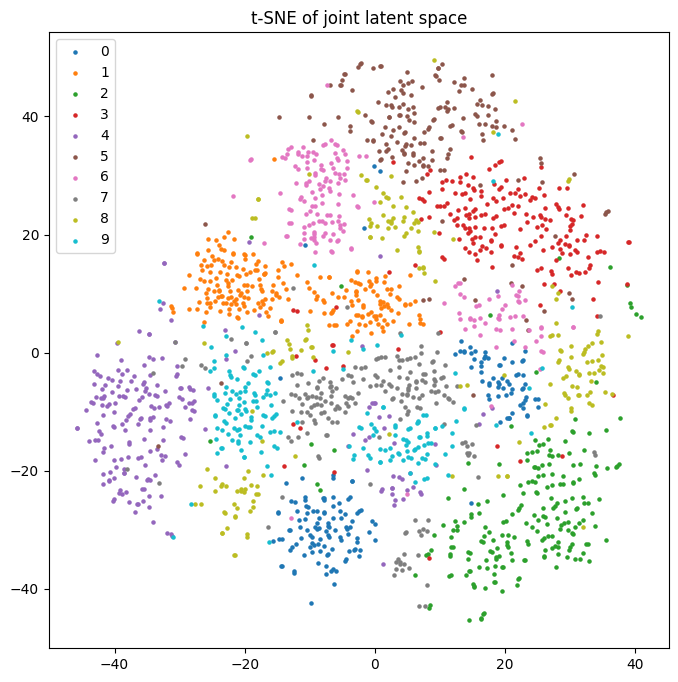

In [69]:
def compute_latents(model, dataloader, device, max_samples=2000):
    model.eval()
    zs = []
    ys = []
    with torch.no_grad():
        for mn, sv, lbl in tqdm(dataloader, desc="Collect latents"):
            mn = mn.to(device); sv = sv.to(device)
            mu_m, logvar_m = model.enc_mnist(mn)
            mu_s, logvar_s = model.enc_svhn(sv)
            mu_joint, logvar_joint = product_of_experts([mu_m, mu_s, torch.zeros_like(mu_m)], [logvar_m, logvar_s, torch.zeros_like(mu_m)])
            zs.append(mu_joint.cpu().numpy())
            ys.append(lbl.numpy())
            if sum(arr.shape[0] for arr in zs) >= max_samples:
                break
    zs = np.concatenate(zs, axis=0)[:max_samples]
    ys = np.concatenate(ys, axis=0)[:max_samples]
    return zs, ys

zs, ys = compute_latents(model, test_loader, device, max_samples=2000)
tsne = TSNE(n_components=2, perplexity=30, init='pca', random_state=42)
z2 = tsne.fit_transform(zs)
plt.figure(figsize=(8,8))
for d in range(10):
    mask = (ys==d)
    plt.scatter(z2[mask,0], z2[mask,1], s=5, label=str(d))
plt.legend()
plt.title("t-SNE of joint latent space")
plt.show()